In [1]:
import numpy as np
import pandas as pd 
from glob import glob
import matplotlib.pyplot as plt
from skimage import io
import seaborn as sns
import warnings
warnings.simplefilter('ignore')
import cv2
import os

In [2]:
!pip install Keras-Preprocessing

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 651.0 kB/s eta 0:00:000:00:01


In [4]:
import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers
#from gradcam import VizGradCAM
# from keras import backend as K
import tensorflow.keras.backend as K
# import tensorflow.keras.layers as L
from keras.models import Sequential, load_model, Model
# https://stackoverflow.com/questions/58047454/how-to-fix-module-keras-backend-tensorflow-backend-has-no-attribute-is-tf

*  ChestX-ray8 dataset which contains 108,948 frontal-view X-ray images of 32,717 unique patients
* diagnose 8 different diseases.
* multilabel classification

In [5]:
# path of the files
DIR = '/kaggle/input/chestxray8-dataframe/train_df.csv'

In [6]:
df = pd.read_csv(DIR)
df.head()

,Image Index,Patient ID,Cardiomegaly,Emphysema,Effusion,No Finding,Hernia,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Pleural_Thickening,Pneumonia,Fibrosis,Edema,Consolidation,FilePath
0,00000001_000.png,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,../input/data/images_001/images/00000001_000.png
1,00000001_001.png,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,../input/data/images_001/images/00000001_001.png
2,00000001_002.png,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,../input/data/images_001/images/00000001_002.png
3,00000002_000.png,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,../input/data/images_001/images/00000002_000.png
4,00000003_000.png,3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,../input/data/images_001/images/00000003_000.png


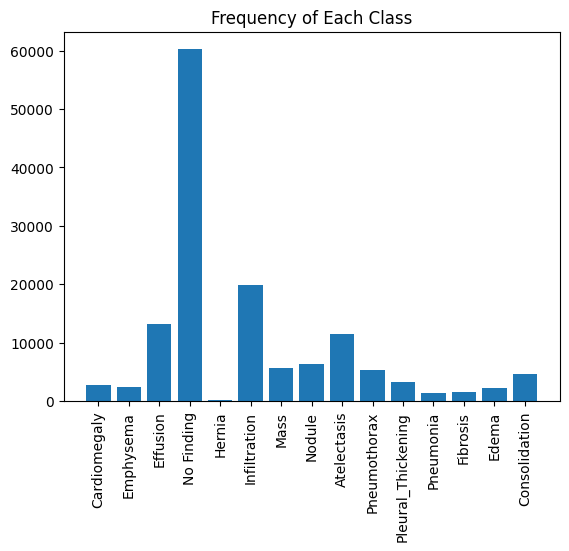

In [7]:
plt.xticks(rotation=90)
plt.bar(x = df.columns[2:-1], height=np.sum(df.iloc[:,2:-1], axis=0))
plt.title("Frequency of Each Class")
plt.show()

We must drop 'No finding' as it is not useful in our case

In [8]:
df.drop(['No Finding'], axis = 1, inplace = True)

In [9]:
df.shape

(111863, 17)

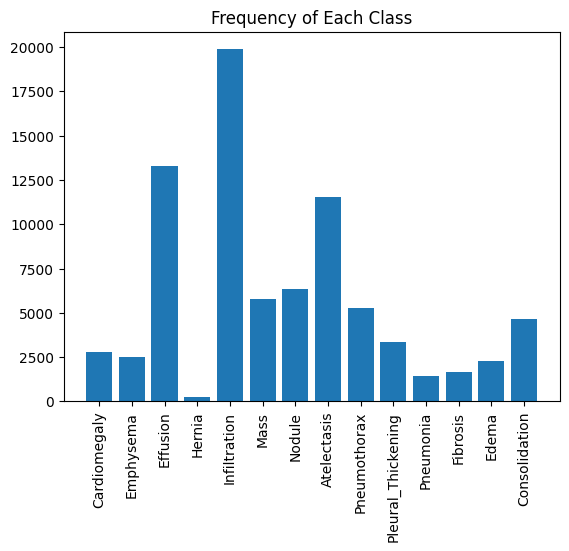

In [10]:
plt.xticks(rotation=90)
plt.bar(x = df.columns[2:-1], height=np.sum(df.iloc[:,2:-1], axis=0))
plt.title("Frequency of Each Class")
plt.show()

In [11]:
def plotimg(path):
    img = plt.imread(path)
    plt.imshow(img, cmap = 'gray')
    print('Shape of image - ',np.array(img).shape)
    plt.show()

def plotimgcv(img):
    plt.imshow(img)
    print('Shape of image - ',np.array(img).shape)
    plt.show()

Shape of image -  (1024, 1024)


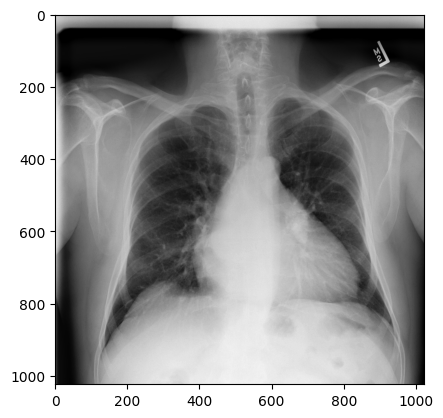

Class - Image Index                                           00000001_001.png
Patient ID                                                           1
Cardiomegaly                                                         1
Emphysema                                                            1
Effusion                                                             0
Hernia                                                               0
Infiltration                                                         0
Mass                                                                 0
Nodule                                                               0
Atelectasis                                                          0
Pneumothorax                                                         0
Pleural_Thickening                                                   0
Pneumonia                                                            0
Fibrosis                                                             

In [13]:
# viz original images
plotimg(df.loc[1, 'FilePath'])
print('Class -',df.loc[1])

Hence the patient has multiple lung infections, and the image is grayscale

In [14]:
# unsharp masking 
def umasking(img):
    test=img.copy()
    smooth = cv2.GaussianBlur(test, (0, 0), 2.0)
    unsharp = cv2.addWeighted(test, 2, smooth, -1, 0)
    return unsharp

# histogram equalization
def histequal(img):
    test=img.copy()
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl1 = clahe.apply(test)
    return cl1

# https://stackoverflow.com/questions/12023958/what-does-cvnormalize-src-dst-0-255-norm-minmax-cv-8uc1
def preprocess(img):
    grayimage = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img_n = cv2.normalize(src=grayimage, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    imgup = umasking(img_n)
    grayimg = histequal(imgup)
    rgbimg = cv2.cvtColor(grayimg, cv2.COLOR_GRAY2RGB)
    return rgbimg

Shape of image -  (1024, 1024, 3)


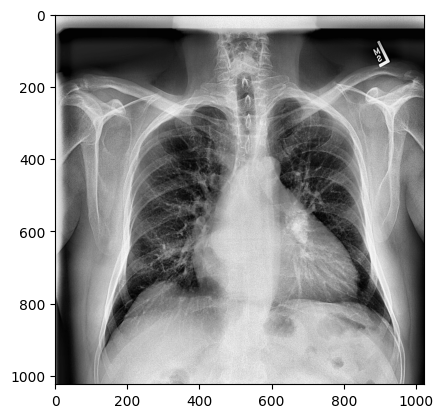

In [15]:
# test the preprocessing
img = cv2.imread(df.loc[1, 'FilePath'], cv2.IMREAD_GRAYSCALE)
imgup = umasking(img)
imgup1 = histequal(imgup)
bgrimg = cv2.cvtColor(imgup1, cv2.COLOR_GRAY2BGR)
plotimgcv(bgrimg)

In [16]:
# dataset parameters
CLASS_MODE = 'raw' # as the class labels have numeric probabilities
TARGET_SIZE = (224,224)
EPOCHS = 5 
BATCH_SIZE = 32 

In [17]:
# Record the labels
labels = df.columns[2:-1]
labels

Index(['Cardiomegaly', 'Emphysema', 'Effusion', 'Hernia', 'Infiltration',
       'Mass', 'Nodule', 'Atelectasis', 'Pneumothorax', 'Pleural_Thickening',
       'Pneumonia', 'Fibrosis', 'Edema', 'Consolidation'],
      dtype='object')

In [18]:
# preprocessing on each image
def create_datagen():
    return ImageDataGenerator(preprocessing_function = preprocess)

In [19]:
def create_train_gen(datagen, traindata):
    return datagen.flow_from_dataframe(
        traindata, 
        x_col='FilePath', 
        y_col=labels,
        class_mode=CLASS_MODE,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=True
    )

In [20]:
def create_val_gen(datagen, val_data): 
    return datagen.flow_from_dataframe(
        val_data, 
        x_col='FilePath', 
        y_col=labels,
        class_mode=CLASS_MODE,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=False
    )

In [21]:
# test
def create_test_gen(datagen, testdata): 
    return datagen.flow_from_dataframe(
        testdata, 
        x_col='FilePath', 
        y_col=labels,
        class_mode=CLASS_MODE,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=False,
    )

Split data into train and validation sets

In [22]:
from sklearn.model_selection import train_test_split

trainvalsplit, testsplit = train_test_split(df, test_size=0.2, random_state=42)
trainsplit, valsplit = train_test_split(trainvalsplit, test_size=0.2, random_state=42)

In [23]:
print(trainsplit.shape, valsplit.shape, testsplit.shape)

(71592, 17) (17898, 17) (22373, 17)


In [24]:
# preprocessed images = Takes 6 mins to run
data_generator = create_datagen()
train_gen = create_train_gen(data_generator, trainsplit)
val_gen = create_val_gen(data_generator, valsplit)
test_gen = create_test_gen(data_generator, testsplit)

Found 71592 validated image filenames.
Found 17898 validated image filenames.
Found 22373 validated image filenames.


Plot the preprocessed images

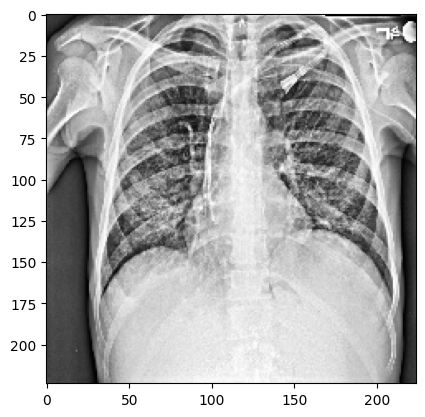

In [25]:
x, y = val_gen.__getitem__(0)
plt.imshow(x[2]/255)
# https://stackoverflow.com/questions/70284922/image-data-generator-not-producing-image-after-giving-preprocessing-function-arg

Address Class imbalance using freq weighted loss

In [65]:
def compute_class_freqs(labels):
    """
    Compute positive and negative frequences for each class.

    Args:
        labels (np.array): matrix of labels, size (num_examples, num_classes)
    Returns:
        positive_frequencies (np.array): array of positive frequences for each
                                         class, size (num_classes)
        negative_frequencies (np.array): array of negative frequences for each
                                         class, size (num_classes)
    """
    N = labels.shape[0]
    
    n_class = labels.shape[1]
    
    positive_frequencies = np.sum(labels==1,axis=0)/N
    negative_frequencies = np.sum(labels==0,axis=0)/N

    ### END CODE HERE ###
    return positive_frequencies, negative_frequencies

In [66]:
freq_pos, freq_neg = compute_class_freqs(train_gen.labels)
#labels = newtrain_df.columns[3:]
#freq_pos, freq_neg = compute_class_freqs(newtrain_df.iloc[:,3:])
freq_pos

array([0.02456978, 0.0219857 , 0.11907755, 0.0020114 , 0.1777992 ,
       0.05124874, 0.05609565, 0.10258129, 0.04693262, 0.030157  ,
       0.01262711, 0.01511342, 0.02049112, 0.04140127])

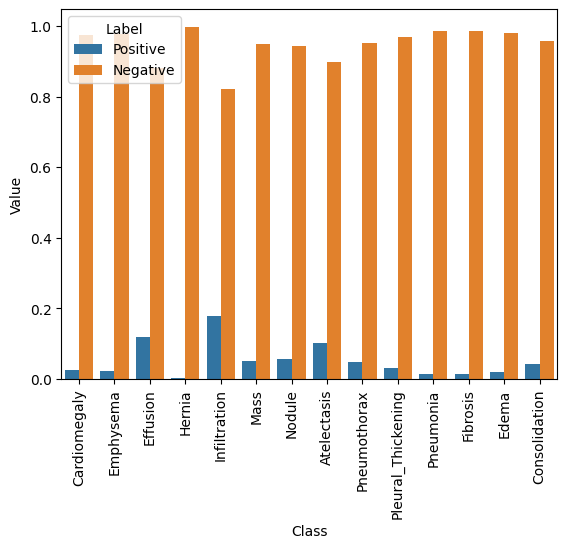

In [67]:
data = pd.DataFrame({"Class": trainsplit.columns[2:-1], "Label": "Positive", "Value": freq_pos})
data = pd.concat([data, pd.DataFrame({"Class": trainsplit.columns[2:-1][l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg))], ignore_index=True)
# https://stackoverflow.com/questions/75956209/error-dataframe-object-has-no-attribute-append
plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label" ,data=data)

In [68]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights

<Axes: xlabel='Class', ylabel='Value'>

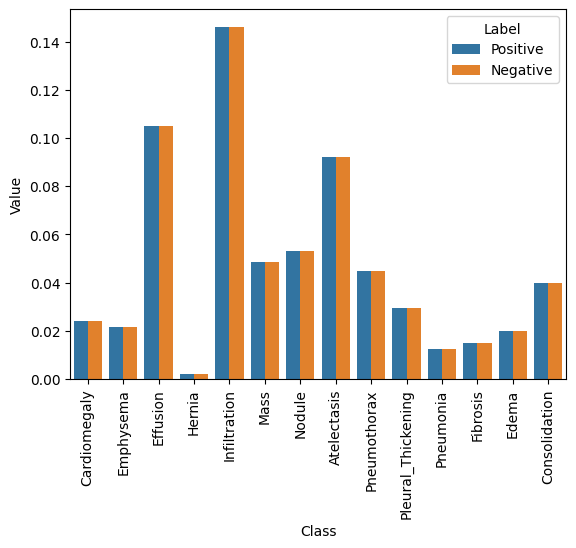

In [69]:
data = pd.DataFrame({"Class": trainsplit.columns[2:-1], "Label": "Positive", "Value": pos_contribution})
data = pd.concat([data, pd.DataFrame({"Class": trainsplit.columns[2:-1][l], "Label": "Negative", "Value": v} 
                        for l,v in enumerate(neg_contribution))], ignore_index=True)
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label" ,data=data)

In [73]:
import keras 
import tensorflow.keras.backend as K
# from keras import backend as K ## gives error

# weighted loss
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    """
    Return weighted loss function given negative weights and positive weights.

    Args:
      pos_weights (np.array): array of positive weights for each class, size (num_classes)
      neg_weights (np.array): array of negative weights for each class, size (num_classes)
    
    Returns:
      weighted_loss (function): weighted loss function
    """
    
    
    def weighted_loss(y_true, y_pred):
        """
        Return weighted loss value. 

        Args:
            y_true (Tensor): Tensor of true labels, size is (num_examples, num_classes)
            y_pred (Tensor): Tensor of predicted labels, size is (num_examples, num_classes)
        Returns:
            loss (float): overall scalar loss summed across all classes
        """
        # initialize loss to zero
        loss = 0.0
        
        ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
        y_true = tf.cast(y_true, tf.float32)
        
        for i in range(len(pos_weights)):
            # for each class, add average weighted loss for that class 
            loss_pos = -1*K.mean(pos_weights[i]*y_true[:,i]*K.log(y_pred[:,i]+epsilon))
            loss_neg = -1*K.mean(neg_weights[i]*(1-y_true[:,i])*K.log(1-y_pred[:,i]+epsilon))
            loss += loss_pos + loss_neg #complete this line
        return loss
    
        ### END CODE HERE ###
    return weighted_loss

In [74]:
def weighted_log_loss(y_true, y_pred):
    """
    Can be used as the loss function in model.compile()
    ---------------------------------------------------
    """
    
    class_weights = np.array([2., 1., 1., 1., 1., 1.])
    
    eps = K.epsilon()
    
    y_pred = K.clip(y_pred, eps, 1.0-eps)

    out = -(         y_true  * K.log(      y_pred) * class_weights
            + (1.0 - y_true) * K.log(1.0 - y_pred) * class_weights)
    
    return K.mean(out, axis=-1)


def _normalized_weighted_average(arr, weights=None):
    """
    A simple Keras implementation that mimics that of 
    numpy.average(), specifically for this competition
    """
    
    if weights is not None:
        scl = K.sum(weights)
        weights = K.expand_dims(weights, axis=1)
        return K.sum(K.dot(arr, weights), axis=1) / scl
    return K.mean(arr, axis=1)


def weighted_loss(y_true, y_pred):
    """
    Will be used as the metric in model.compile()
    ---------------------------------------------
    
    Similar to the custom loss function 'weighted_log_loss()' above
    but with normalized weights, which should be very similar 
    to the official competition metric:
        https://www.kaggle.com/kambarakun/lb-probe-weights-n-of-positives-scoring
    and hence:
        sklearn.metrics.log_loss with sample weights
    """
    
    class_weights = K.variable([2., 1., 1., 1., 1., 1.])
    
    eps = K.epsilon()
    
    y_pred = K.clip(y_pred, eps, 1.0-eps)

    loss = -(        y_true  * K.log(      y_pred)
            + (1.0 - y_true) * K.log(1.0 - y_pred))
    
    loss_samples = _normalized_weighted_average(loss, class_weights)
    
    return K.mean(loss_samples)

Model creation

1. Mobilenet

In [76]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from keras.applications import MobileNet
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint


# how we define a MobileNet model
def build_model():
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape = (224,224,3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
#     x = Dense(256, activation='relu')(x)
#     x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(len(labels), activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    # freeze layers in base model
    for layer in base_model.layers:
        layer.trainable = False

    return model

model = build_model()
model.compile(optimizer=Adam(0.001), 
              loss=get_weighted_loss(pos_weights, neg_weights), 
              metrics=['accuracy'])


# training
history = model.fit(
    train_gen,
    steps_per_epoch=len(train_gen) // BATCH_SIZE,
    validation_data=val_gen,
    validation_steps=len(val_gen) // BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[ModelCheckpoint('/kaggle/working/model.keras', save_best_only=True)]
)

Epoch 1/5
 1/69 ━━━━━━━━━━━━━━━━━━━━ 19:01 17s/step - accuracy: 0.0000e+00 - auc_6: 0.3623 - loss: 1.6888

W0000 00:00:1714351008.183017     132 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 759ms/step - accuracy: 0.0555 - auc_6: 0.5021 - loss: 1.0266

W0000 00:00:1714351064.958545     134 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


69/69 ━━━━━━━━━━━━━━━━━━━━ 82s 952ms/step - accuracy: 0.0557 - auc_6: 0.5027 - loss: 1.0256 - val_accuracy: 0.0735 - val_auc_6: 0.5362 - val_loss: 0.9145
Epoch 2/5
69/69 ━━━━━━━━━━━━━━━━━━━━ 63s 926ms/step - accuracy: 0.1085 - auc_6: 0.5416 - loss: 0.9269 - val_accuracy: 0.1195 - val_auc_6: 0.5424 - val_loss: 0.9106
Epoch 3/5
69/69 ━━━━━━━━━━━━━━━━━━━━ 62s 905ms/step - accuracy: 0.1522 - auc_6: 0.5491 - loss: 0.8840 - val_accuracy: 0.0331 - val_auc_6: 0.5393 - val_loss: 0.9000
Epoch 4/5
69/69 ━━━━━━━━━━━━━━━━━━━━ 50s 741ms/step - accuracy: 0.0486 - auc_6: 0.5441 - loss: 0.9019 - val_accuracy: 0.0717 - val_auc_6: 0.5801 - val_loss: 0.8789
Epoch 5/5
69/69 ━━━━━━━━━━━━━━━━━━━━ 47s 696ms/step - accuracy: 0.0581 - auc_6: 0.5373 - loss: 0.9038 - val_accuracy: 0.0790 - val_auc_6: 0.5709 - val_loss: 0.8853


In [78]:
test_gen.labels

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [82]:
yp = model.predict(test_gen, steps = len(test_gen)// BATCH_SIZE)

21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 524ms/step


In [83]:
yp.round()

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 1., 1., 0.],
       ...,
       [0., 0., 1., ..., 0., 1., 1.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 1., 0.]], dtype=float32)

In [86]:
model.evaluate(test_gen)

21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 523ms/step - accuracy: 0.0699 - auc_6: 0.5858 - loss: 0.8415


[0.8755733966827393, 0.5836941599845886, 0.0773809552192688]

In [89]:
y_true.shape

(22373, 14)

In [90]:
yp.shape

(672, 14)

In [92]:
# evaluate the model on the test set
y_true = test_gen.labels
y_pred = model.predict(test_gen) # takes 6 mins

# calculate and print metrics
loss, auc, accuracy = model.evaluate(test_gen) # takes 6 mins
precision = precision_score(y_true, y_pred.round(), average='weighted')
recall = recall_score(y_true, y_pred.round(), average='weighted')
f1 = f1_score(y_true, y_pred.round(), average='weighted')
roc_auc = roc_auc_score(y_true, y_pred)
# Above = https://stackoverflow.com/questions/46732881/how-to-calculate-f1-score-for-multilabel-classification

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("ROC AUC Score:", roc_auc)
print("AUC Score:", auc)
print("Mean ROC AUC Score:", roc_auc.mean())



  9/700 ━━━━━━━━━━━━━━━━━━━━ 6:00 521ms/step

KeyboardInterrupt: 

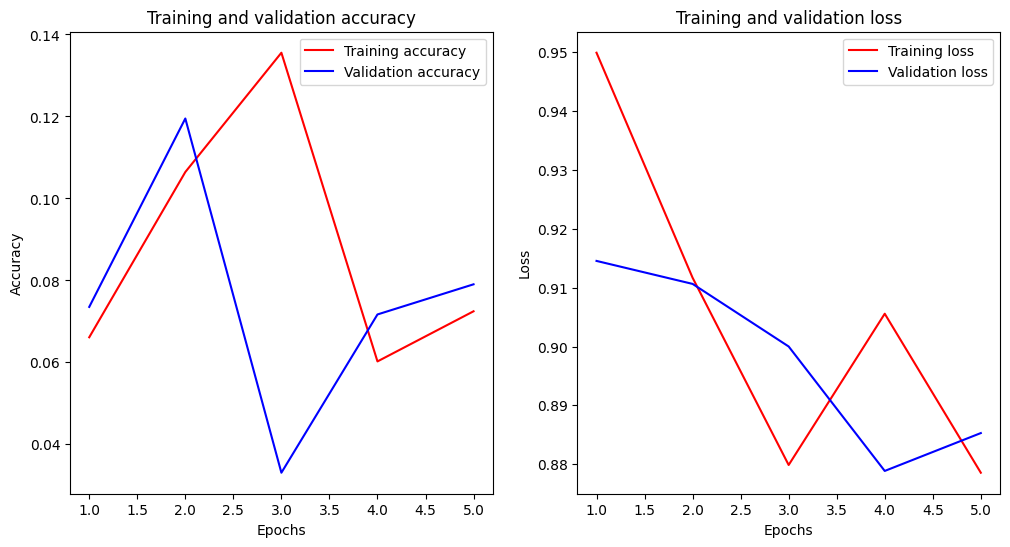

In [93]:
# plot the training and validation accuracy/loss curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
# auc = history.history['auc']
# val_auc = history.history['val_auc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r-', label='Training accuracy')
plt.plot(epochs, val_acc, 'b-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r-', label='Training loss')
plt.plot(epochs, val_loss, 'b-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

2. VGG

In [ ]:
from keras.applications import VGG16


# how we define your VGG model
def build_model1():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape = (224,224,3))

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
#     x = Dense(64, activation='relu')(x)
#     x = Dropout(0.5)(x)
    predictions = Dense(len(labels), activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # freeze layers in base model
    for layer in base_model.layers:
        layer.trainable = False

    return model

# compile the model with our defined function
model1 = build_model1()
model1.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])


# train the model
history = model1.fit(
    train_gen,
#     steps_per_epoch=train_gen.n // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_gen,
#     validation_steps=val_gen.n // BATCH_SIZE,
    callbacks=[ModelCheckpoint('/kaggle/working/model.keras', save_best_only=True)]
)

In [ ]:
# evaluate the model on the test set
y_true = test_gen.classes
y_pred = model1.predict(test_gen)

# calculate and print metrics
loss, accuracy = model1.evaluate(test_gen)
precision = precision_score(y_true, y_pred.round())
recall = recall_score(y_true, y_pred.round())
f1 = f1_score(y_true, y_pred.round())
roc_auc = roc_auc_score(y_true, y_pred)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("ROC AUC Score:", roc_auc)

# plot the training and validation accuracy/loss curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r-', label='Training accuracy')
plt.plot(epochs, val_acc, 'b-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r-', label='Training loss')
plt.plot(epochs, val_loss, 'b-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

3. Resnet50

In [ ]:
from keras.applications import ResNet50


# how we define your ResNet model
def build_model2():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape = (224,224,3))

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(len(labels), activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # freeze layers in base model
    for layer in base_model.layers:
        layer.trainable = False

    return model

# compile the model using the above function
model2 = build_model2()
model2.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

# train the model
history = model2.fit(
    train_gen,
#     steps_per_epoch=train_gen.n // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_gen,
#     validation_steps=val_gen.n // BATCH_SIZE,
    callbacks=[ModelCheckpoint('/kaggle/working/model.keras', save_best_only=True)]
)

In [ ]:
# evaluate the model with our test set
y_true = test_gen.classes
y_pred = model2.predict(test_gen)

# calculate and print metrics
loss, accuracy = model2.evaluate(test_gen)
precision = precision_score(y_true, y_pred.round())
recall = recall_score(y_true, y_pred.round())
f1 = f1_score(y_true, y_pred.round())
roc_auc = roc_auc_score(y_true, y_pred)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("ROC AUC Score:", roc_auc)

# plot the training and validation accuracy/loss curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r-', label='Training accuracy')
plt.plot(epochs, val_acc, 'b-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r-', label='Training loss')
plt.plot(epochs, val_loss, 'b-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

4. Densenet

In [ ]:
from keras.applications import DenseNet121


# how we defined your DenseNet model
def build_model3():
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape = (224,224,3))

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(len(labels), activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # freeze layers in base model
    for layer in base_model.layers:
        layer.trainable = False

    return model

# compile the model with the above function
model3 = build_model3()
model3.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])


# training the model
history = model3.fit(
    train_gen,
#     steps_per_epoch=train_gen.n // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_gen,
#     validation_steps=val_gen.n // BATCH_SIZE,
    callbacks=[ModelCheckpoint('/kaggle/working/model.keras', save_best_only=True)]
)

In [ ]:
# evaluate the model on the test set
y_true = test_gen.classes
y_pred = model3.predict(test_gen)

# calculate and print the metrics
loss, accuracy = model3.evaluate(test_gen)
precision = precision_score(y_true, y_pred.round())
recall = recall_score(y_true, y_pred.round())
f1 = f1_score(y_true, y_pred.round())
roc_auc = roc_auc_score(y_true, y_pred)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("ROC AUC Score:", roc_auc)

# plot the training and validation accuracy/loss curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r-', label='Training accuracy')
plt.plot(epochs, val_acc, 'b-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r-', label='Training loss')
plt.plot(epochs, val_loss, 'b-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

5. Vision Transformer

ROC CURVES

In [ ]:
# pred_Y = multi_disease_model.predict(test_X, batch_size = 32, verbose = True)
# test_Y = 

In [ ]:
# this plot code is from source = https://www.kaggle.com/code/kmader/train-simple-xray-cnn#Continued-Training
from sklearn.metrics import roc_curve, auc

fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('trained_net.png')

GradCAM

In [100]:
def gradcam(lastconvlayer,img,gt,model,CLASS_INDEX=None):
    grad_model = Model(inputs=model.inputs, outputs=[model.get_layer(lastconvlayer).output, model.output])
    io_img = np.expand_dims(img, axis=0)
    print('Image shape -',io_img.shape)

    ###--Compute GRADIENT
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(io_img)
    ##--   Below is for multiclass
        if CLASS_INDEX is None:
            CLASS_INDEX = tf.math.round(predictions[0][0])
        class_channel = predictions[0]

    # Extract filters and gradients
    output = conv_outputs[0]
    grads = tape.gradient(class_channel, conv_outputs)
    print('Gradients shape', grads.shape)
    print('Prediction', predictions)
    print('Ground truth', gt)
    
    # spatially average
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
    # matmul the gradients with the convolution outputs
    heatmap = output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    # normalize heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [95]:
# Below visualization code is from source = https://keras.io/examples/vision/grad_cam/
from IPython.display import Image, display
import matplotlib
import keras

def save_and_display_gradcam(heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = image[0][0]

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = matplotlib.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))

1. For Densenet

In [ ]:
y_true = test_gen.classes
y_pred = model3.predict(test_gen)
# check which ones are incorrect preds
[i for i, x in enumerate(y_true) if y_true[i]!=y_pred[i].round()]

In [ ]:
# model.summary() 

In [101]:
image = next(test_gen)
lastconvlayer = 'conv5_block16_2_conv'

heatmap = gradcam(lastconvlayer, image[0][4], image[1][4], model3)

plt.matshow(heatmap)
plt.show()

NameError: name 'model3' is not defined

In [ ]:
save_and_display_gradcam(heatmap)

2. For Mobilenet

In [1]:
# y_true = test_gen.classes
# y_pred = model.predict(test_gen)
# check which ones are incorrect preds
# [i for i, x in enumerate(y_true) if y_true[i]!=y_pred[i].round()]

In [98]:
# model.summary() 

Image shape - (1, 224, 224, 3)
Gradients shape (1, 7, 7, 1024)
Prediction tf.Tensor(
[[0.4972215  0.49432045 0.5812278  0.53583616 0.5807387  0.46695554
  0.4753137  0.52006125 0.49599543 0.47563386 0.4738546  0.4513081
  0.57344985 0.5390715 ]], shape=(1, 14), dtype=float32)
Ground truth [0 0 0 0 1 0 0 0 0 0 0 0 0 0]


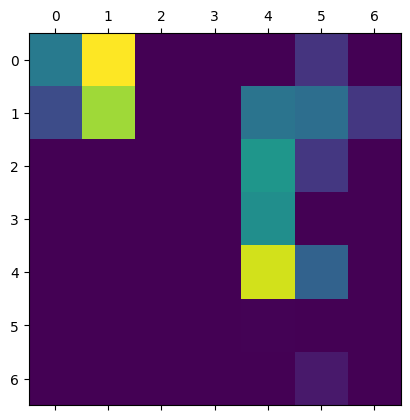

In [102]:
image = next(test_gen)
lastconvlayer = 'conv_pw_13'

heatmap = gradcam(lastconvlayer, image[0][4], image[1][4], model)

plt.matshow(heatmap)
plt.show()

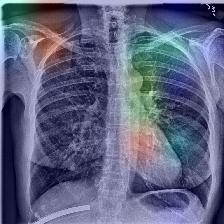

In [103]:
save_and_display_gradcam(heatmap)